# <b> Part 5. 딥러닝으로 정교하게 예측하기</b>

### 인공신경망 응용 사례

In [ ]:
# 텐서플로를 이용한 인공신경망 구현

In [ ]:
import tensorflow as tf

In [ ]:
# Load MNIST data set
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Change image data type to float32
x_train, x_test = x_train.astype('float32'), x_test.astype('float32')
# print(x_train.shape) #(60000, 28, 28)
# Reshape: Flatten 28 * 28 to 784D (reshape)
x_train, x_test = x_train.reshape([-1, 784]), x_test.reshape([-1, 784])
# print(x_train.shape) #(60000, 784)
# Normalize Input : [0, 255] -->  [0, 1] 
x_train, x_test = x_train / 255., x_test / 255.
# print(x_train.shape) #(60000, 784)
# One-hot encoding Labels
y_train, y_test = tf.one_hot(y_train, depth=10), tf.one_hot(y_test, depth=10)

In [ ]:
 # Define params.
learning_rate = 0.001 # 학습률
num_epochs = 30       # 학습횟수
batch_size = 256      # 배치개수
display_step = 1      # 손실함수 출력 주기
input_size = 784      # 28 * 28
hidden1_size = 256
hidden2_size = 256
output_size = 10

In [ ]:
# Shuffle data 
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(60000).batch(batch_size)

In [ ]:
# Define ANN network
class ANN(object):
  # Define tf.Variable
  def __init__(self):
    self.W1 = tf.Variable(tf.random.normal(shape=[input_size, hidden1_size]))
    self.b1 = tf.Variable(tf.random.normal(shape=[hidden1_size]))
    self.W2 = tf.Variable(tf.random.normal(shape=[hidden1_size, hidden2_size]))
    self.b2 = tf.Variable(tf.random.normal(shape=[hidden2_size]))
    self.W_output = tf.Variable(tf.random.normal(shape=[hidden2_size, output_size]))
    self.b_output = tf.Variable(tf.random.normal(shape=[output_size]))

  def __call__(self, x):
    H1_output = tf.nn.relu(tf.matmul(x, self.W1) + self.b1)
    H2_output = tf.nn.relu(tf.matmul(H1_output, self.W2) + self.b2)
    logits = tf.matmul(H2_output, self.W_output) + self.b_output

    return logits

In [ ]:
# Define  Loss function: Cross-entropy
@tf.function
def cross_entropy_loss(logits, y):
  return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

In [ ]:
# Define Optimizer: Adam
optimizer = tf.optimizers.Adam(learning_rate)

In [ ]:
# Define function for optimization
@tf.function
def train_step(model, x, y):
  with tf.GradientTape() as tape:
    y_pred = model(x)
    loss = cross_entropy_loss(y_pred, y)
  gradients = tape.gradient(loss, vars(model).values())
  optimizer.apply_gradients(zip(gradients, vars(model).values()))

In [ ]:
# Define function for model accuracy
@tf.function
def compute_accuracy(y_pred, y):
  correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

  return accuracy

In [ ]:
# Start ANN model 
ANN_model = ANN()

# Model Optimization
for epoch in range(num_epochs):
  average_loss = 0.
  total_batch = int(x_train.shape[0] / batch_size)
  # Optimize for every batch
  for batch_x, batch_y in train_data:
    # Update params. 
    _, current_loss = train_step(ANN_model, batch_x, batch_y), cross_entropy_loss(ANN_model(batch_x), batch_y)
    # Compute average loss
    average_loss += current_loss / total_batch
  # Display every epoch
  if epoch % display_step == 0:
    print("Epoch: %d, Loss: %f" % ((epoch+1), average_loss))

# Print Test Accuracy
print("Accuracy: %f" % compute_accuracy(ANN_model(x_test), y_test))  

Epoch: 1, Loss: 221.902908
Epoch: 2, Loss: 56.227772
Epoch: 3, Loss: 37.056839
Epoch: 4, Loss: 27.538637
Epoch: 5, Loss: 21.374392
Epoch: 6, Loss: 17.055250
Epoch: 7, Loss: 13.779185
Epoch: 8, Loss: 11.183573
Epoch: 9, Loss: 9.152012
Epoch: 10, Loss: 7.439732
Epoch: 11, Loss: 6.128031
Epoch: 12, Loss: 5.010097
Epoch: 13, Loss: 4.044858
Epoch: 14, Loss: 3.251103
Epoch: 15, Loss: 2.601694
Epoch: 16, Loss: 2.101364
Epoch: 17, Loss: 1.676236
Epoch: 18, Loss: 1.311410
Epoch: 19, Loss: 1.033323
Epoch: 20, Loss: 0.781060
Epoch: 21, Loss: 0.591698
Epoch: 22, Loss: 0.450093
Epoch: 23, Loss: 0.379132
Epoch: 24, Loss: 0.274849
Epoch: 25, Loss: 0.190573
Epoch: 26, Loss: 0.146151
Epoch: 27, Loss: 0.155766
Epoch: 28, Loss: 0.101572
Epoch: 29, Loss: 0.092752
Epoch: 30, Loss: 0.061473
Accuracy: 0.944000


## <b> Ch 3. 심층신경망(Deep Neural Network) </b>

## <b>Ch 6. 딥러닝을 이용한 시계열 예측</b>

### 데이터 소개

In [1]:
# Jena Climate is weather timeseries dataset recorded at the Weather Station of the Max Planck Institute for Biogeochemistry in Jena, Germany.

In [2]:
# Jena Climate dataset is made up of 14 different quantities (such air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes, over several years.
# This dataset covers data from January 1st 2009 to December 31st 2016.

In [3]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

zip_path = tf.keras.utils.get_file(
  origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
  fname='jena_climate_2009_2016.csv.zip',
  extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 [==============================] - 1s 0us/step


In [4]:
df = pd.read_csv(csv_path)
print(df.head())
print(df.columns)

             Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03        

In [5]:
df.head(15)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
7,01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.50,118.6
8,01.01.2009 01:30:00,996.50,-7.91,265.52,-8.73,93.8,3.36,3.15,0.21,1.97,3.16,1307.17,0.28,0.75,188.5
9,01.01.2009 01:40:00,996.53,-8.43,264.99,-9.34,93.1,3.23,3.00,0.22,1.88,3.02,1309.85,0.59,0.88,185.0


In [6]:
df.tail()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8
420550,01.01.2017 00:00:00,999.82,-4.82,268.36,-8.42,75.70,4.27,3.23,1.04,2.01,3.23,1296.38,1.23,1.96,184.9


### 뉴럴 네트워크를 이용한 기상예측

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [8]:
# Define a specific window for training Neural Network 
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [11]:
TRAIN_SPLIT = 300000 ## about 2083 days, 과거의 30만건 데이터를 학습에 이용
tf.random.set_seed(13) ##

In [12]:
# Extract temperature (degree) data & Make univariate series
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
print(uni_data.head())

[-1.99766294 -2.04281897 -2.05439744 ... -1.43494935 -1.55883897
 -1.62715193]
Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64


In [13]:
# Standardization
uni_data = uni_data.values
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data - uni_train_mean) / uni_train_std  # Standardization

print(uni_data)

[-1.99766294 -2.04281897 -2.05439744 ... -1.43494935 -1.55883897
 -1.62715193]


In [51]:
univariate_past_history = 20
univariate_future_target = 0

## univariate_data 함수 이용
x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                         univariate_past_history,
                                         univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                     univariate_past_history,
                                     univariate_future_target)

print('Single window of past history')
print(x_train_uni[0])
print(x_train_uni[0].shape)
print('\n Target temperature to predict')
print(y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]
(20, 1)

 Target temperature to predict
-2.1041848598100876


In [15]:
# Defind function for Visualization
def create_time_steps(length):
    return list(range(-length, 0))


def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.axis('auto')
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

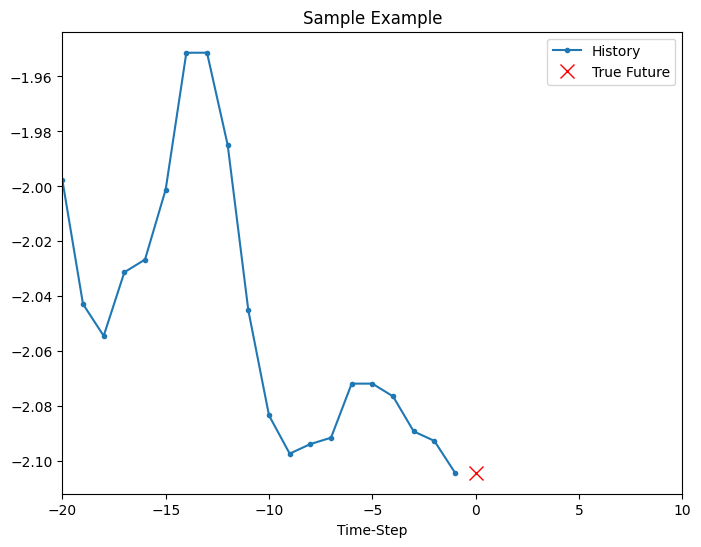

In [16]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example').show()

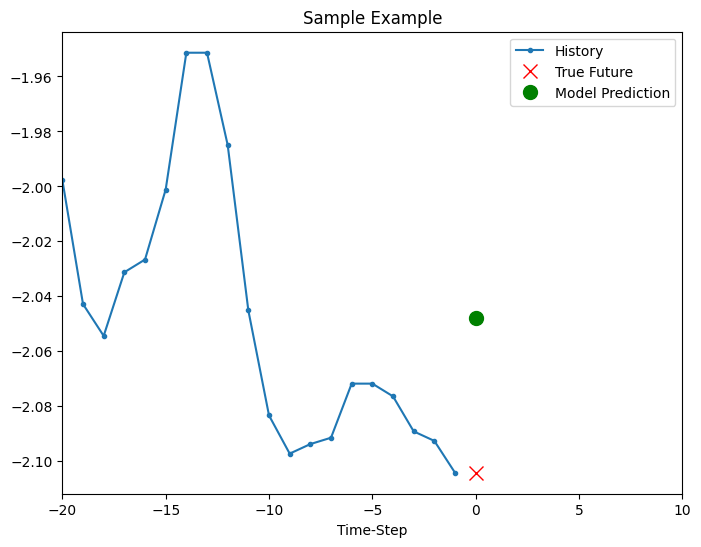

In [19]:
# 20개의 과거 데이터로 현재 예측 
# 단순히 평균한 값으로 예측해서 실제값이랑 너무 차이가남. 
# 시계열에서 평균은 거의 의미가 없다. 물론 변동성이 크지않는 데이터는 큰 의미가 있다.
# 그러나 시계열 데이터는 변동성이 크다. 
def baseline(history):
    return np.mean(history)

show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Sample Example').show()

### LSTM을 이용한 기상예측: 단변량

In [22]:
# shuffle, batch, cache(한번 학습한 결과를 메모리에 저장해두어 메모리에서 데이터를 꺼내 쓴다. 학습이 빨라진다.)

In [23]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

In [24]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [25]:
# LSTM (Long Short Term Memory)

In [30]:
np.array(x_train_uni).shape

(299980, 20, 1)

In [33]:
# 아까와 동일하게 20일간의 데이터만 사용
np.array(x_train_uni).shape[-2:]

(20, 1)

In [40]:
train_univariate

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [41]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=np.array(x_train_uni).shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [35]:
# Train model

In [36]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 9s 21ms/step - loss: 0.4851 - val_loss: 0.1178
Epoch 2/10
200/200 [==============================] - 6s 28ms/step - loss: 0.1128 - val_loss: 0.0343
Epoch 3/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0475 - val_loss: 0.0271
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0441 - val_loss: 0.0234
Epoch 5/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0277 - val_loss: 0.0220
Epoch 6/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0300 - val_loss: 0.0207
Epoch 7/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0278 - val_loss: 0.0199
Epoch 8/10
200/200 [==============================] - 3s 14ms/step - loss: 0.0256 - val_loss: 0.0186
Epoch 9/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0248 - val_loss: 0.0178
Epoch 10/10
200/200 [==============================] - 3s 13ms/step - loss: 0.0226 - val_lo

8/8 [==============================] - 1s 5ms/step


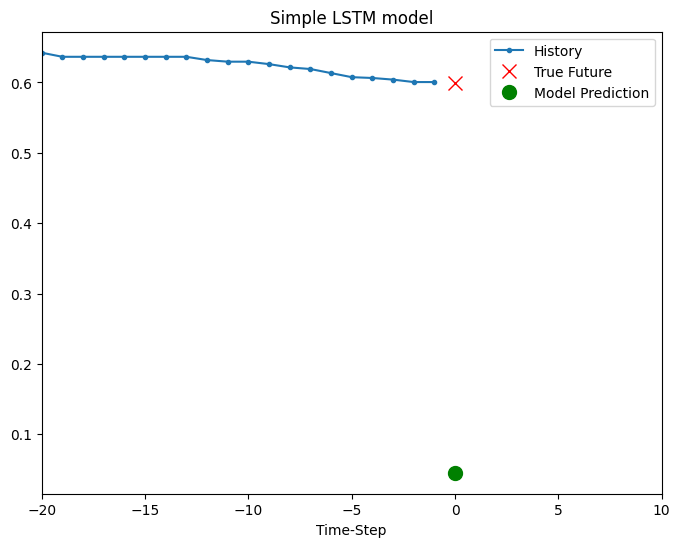

8/8 [==============================] - 0s 4ms/step


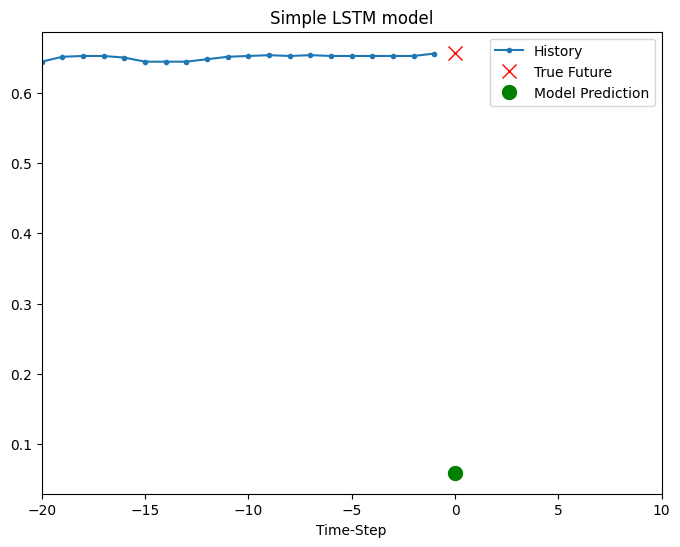

8/8 [==============================] - 0s 5ms/step


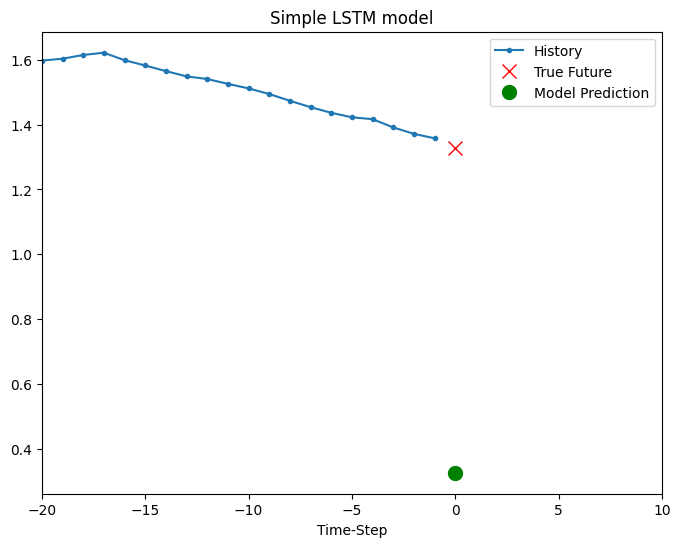

8/8 [==============================] - 0s 3ms/step


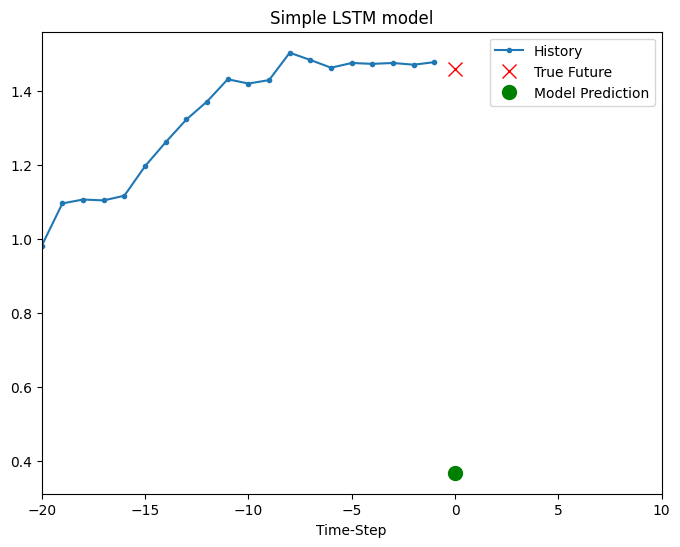

8/8 [==============================] - 0s 3ms/step


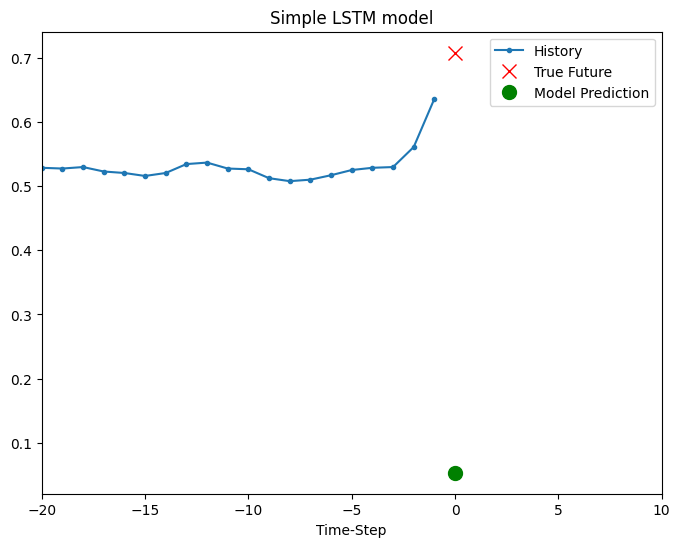

8/8 [==============================] - 0s 3ms/step


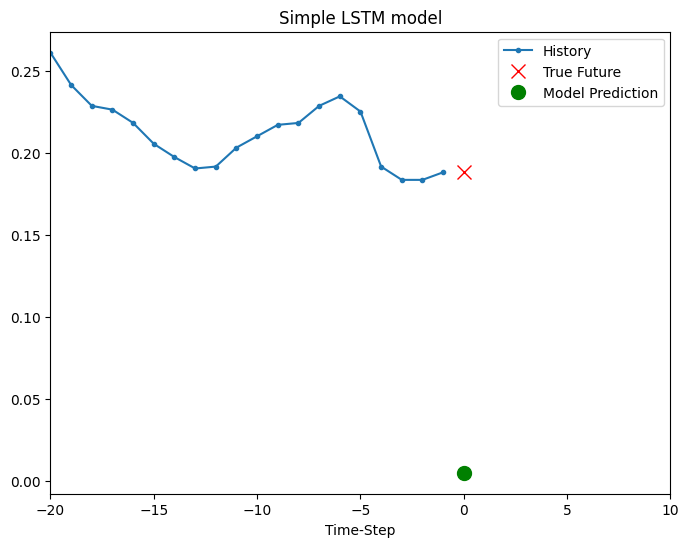

8/8 [==============================] - 0s 3ms/step


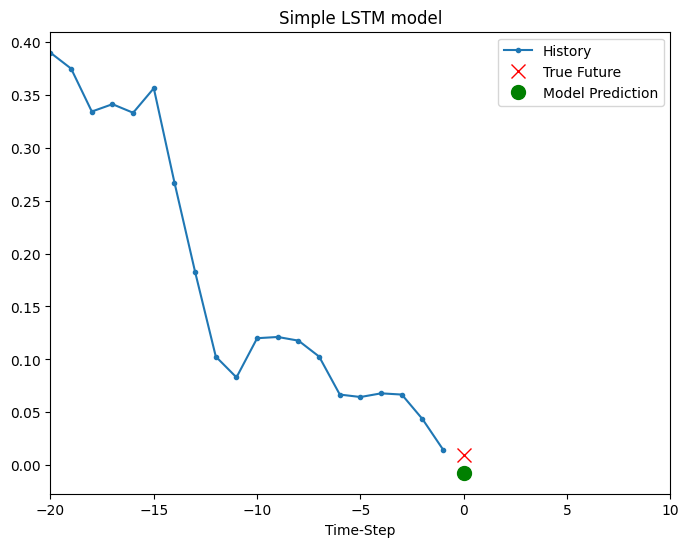

In [42]:
# Make forecasts & Visualize

for x, y in val_univariate.take(7):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                      simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

### LSTM을 이용한 기상예측: 다변량

In [43]:
# 다변량 시계열 데이터 예측하기

In [44]:
# 온도 (air temperature), 기압 (atmospheric pressure), 공기밀도 (air density) 

In [45]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


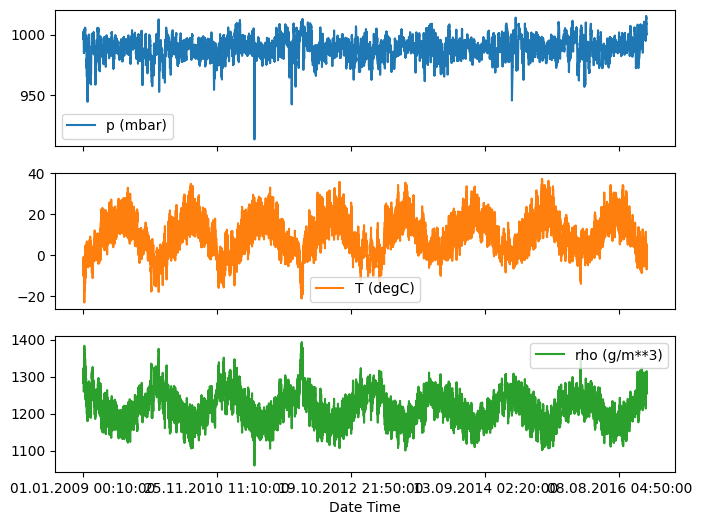

In [46]:
features.plot(subplots=True)
plt.show()

In [47]:
# Standardization

In [48]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std
print(dataset)

[[ 0.95547359 -1.99766294  2.2350791 ]
 [ 0.96154485 -2.04281897  2.28524007]
 [ 0.95668784 -2.05439744  2.29600633]
 ...
 [ 1.35617678 -1.43494935  1.76136375]
 [ 1.35496252 -1.55883897  1.88786728]
 [ 1.35617678 -1.62715193  1.95686921]]


In [49]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i:i + target_size])
    return np.array(data), np.array(labels)

In [54]:
past_history = 720
future_target = 72
STEP = 6
# 입력이 120윈도우(스텝), 3개의 컬럼
# 출력이 72스텝

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0, TRAIN_SPLIT, past_history,
                                                   future_target, STEP, single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1], TRAIN_SPLIT, None, past_history,
                                               future_target, STEP, single_step=True)

print('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


8/8 [==============================] - 1s 13ms/step
(256, 1)
Epoch 1/10
200/200 [==============================] - 30s 141ms/step - loss: 0.3129 - val_loss: 0.2520
Epoch 2/10
200/200 [==============================] - 23s 113ms/step - loss: 0.2645 - val_loss: 0.2393
Epoch 3/10
200/200 [==============================] - 22s 110ms/step - loss: 0.2601 - val_loss: 0.2434
Epoch 4/10
200/200 [==============================] - 23s 115ms/step - loss: 0.2574 - val_loss: 0.2330
Epoch 5/10
200/200 [==============================] - 28s 140ms/step - loss: 0.2273 - val_loss: 0.2352
Epoch 6/10
200/200 [==============================] - 23s 114ms/step - loss: 0.2387 - val_loss: 0.2495
Epoch 7/10
200/200 [==============================] - 22s 112ms/step - loss: 0.2425 - val_loss: 0.2644
Epoch 8/10
200/200 [==============================] - 21s 107ms/step - loss: 0.2414 - val_loss: 0.2546
Epoch 9/10
200/200 [==============================] - 26s 128ms/step - loss: 0.2424 - val_loss: 0.2509
Epoch 10/10


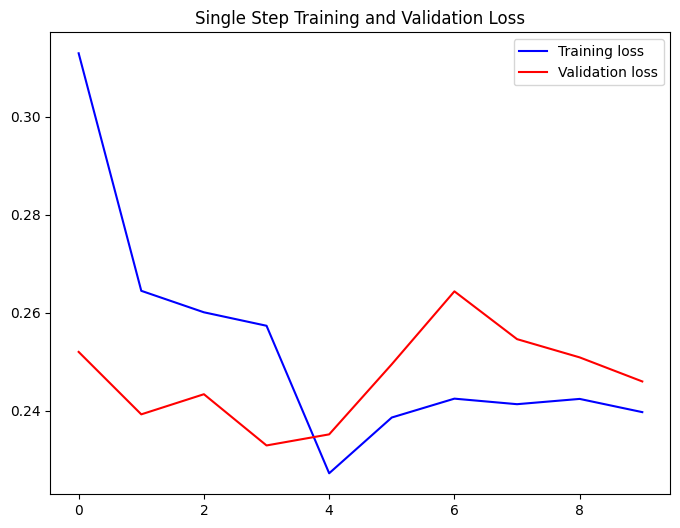

In [53]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)


def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

plot_train_history(single_step_history,
                   'Single Step Training and Validation Loss')

8/8 [==============================] - 0s 26ms/step


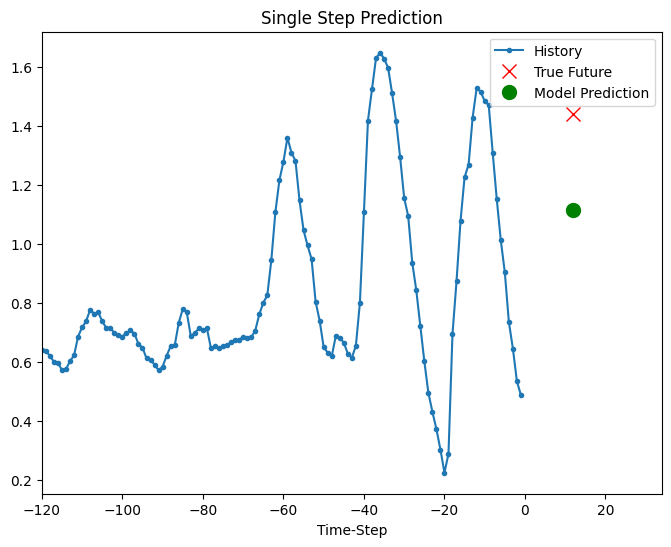

8/8 [==============================] - 0s 14ms/step


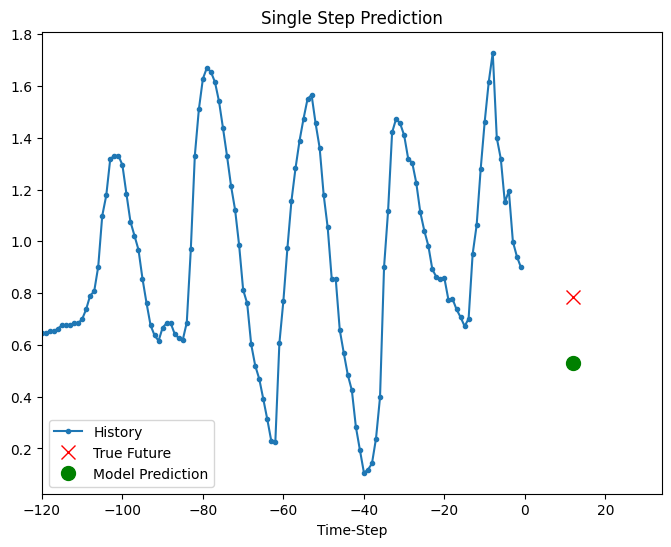

8/8 [==============================] - 0s 13ms/step


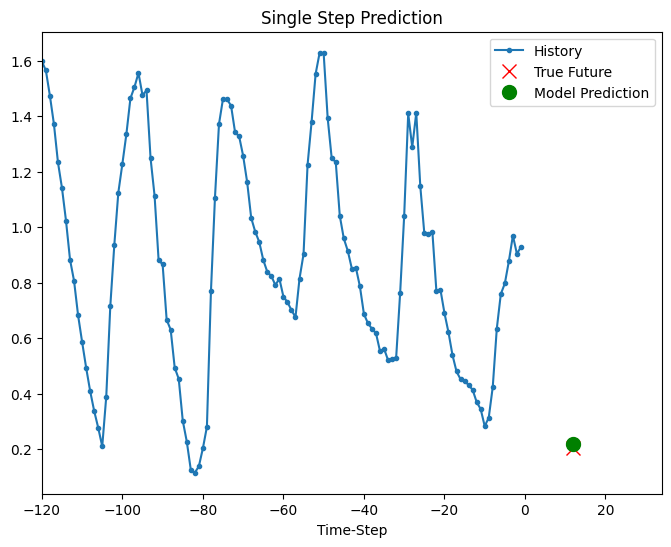

In [55]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                      single_step_model.predict(x)[0]], 12,
                     'Single Step Prediction')
    plot.show()

In [56]:
past_history = 720
future_target = 72
STEP = 6

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history, future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history, future_target, STEP)

print('Single window of past history : {}'.format(x_train_multi[0].shape))
print('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


## <b> Ch 7. Part 5 요약 및 강의 총정리</b>

### 딥러닝과 시계열